In [1]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.utils.data as data_utils

import utils
import USAD

import numpy as np
pd.set_option('display.width', 1000)

In [2]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.

PyTorch version:2.1.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True


In [3]:
device = utils.get_default_device()
# device = torch.device(torch.device("mps:0") if torch.backends.mps.is_available() else 'cpu')

In [4]:
path = './경진대회용 열처리 품질보증 데이터셋/'
df = pd.read_csv(path+'data.csv', encoding='cp949')
df['TAG_MIN']=pd.to_datetime(df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')

dfd = df.describe()
dfd.loc['upper_outlier'] = dfd.loc['75%'] + ((dfd.loc['75%'] - dfd.loc['25%'])*1.5)
dfd.loc['lower_outlier'] = dfd.loc['25%'] - ((dfd.loc['75%'] - dfd.loc['25%'])*1.5)

#### 결측치 처리
##### 초당 샘플링 하기때문에 결측치 drop

In [5]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
def count_outlier(df, dfd):
    columns = list(df.columns)
    columns.remove('TAG_MIN')
    columns.remove('배정번호')

    buff_df1 = pd.DataFrame(index=df.index)

    for column in columns:
        buff_df1[column+'_error'] = 0
        buff_df1[column+'_error'] += ((df[column] > dfd.loc['upper_outlier', column]) | (df[column] < dfd.loc['lower_outlier', column])) * 1.0

    continue_num = 5

    buff_df1 = buff_df1.rolling(window=continue_num).mean()
    buff_df1 = (buff_df1>=1)*1.0

    df = pd.concat([df, buff_df1], axis=1)
    df.drop(index=range(continue_num), inplace=True)
    df.reset_index(drop=True, inplace=True)


    buff_df2 = pd.DataFrame(index=df.index)

    preocesses = ['건조', '세정', '소입', '솔트']

    for process in preocesses:
        buff_df2[process+'_error'] = df[[column for column in df.columns if process in column and 'error' in column]].sum(axis=1)

    df.drop(columns=[column for column in df.columns if 'error' in column], inplace=True)
    df = pd.concat([df, buff_df2], axis=1)
    
    return df

In [7]:
df = count_outlier(df, dfd)

In [8]:
df.drop(columns=['TAG_MIN', '배정번호'], inplace=True)

In [9]:
df

,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,소입4존 OP,소입로 CP 값,...,소입로 온도 3 Zone,소입로 온도 4 Zone,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,솔트조 온도 2 Zone,건조_error,세정_error,소입_error,솔트_error
0,75.9607,29.596700,98.7825,99.2001,68.4275,75.6285,61.1314,51.8036,71.6125,0.450566,...,859.991,859.731,294.721,272.599,328.740,328.869,2.0,0.0,0.0,2.0
1,76.2665,32.172600,98.7825,99.2001,68.4889,70.9577,59.6177,51.8148,71.5936,0.450445,...,859.991,859.731,294.781,272.661,328.740,328.869,2.0,0.0,0.0,2.0
2,76.2216,29.828000,98.7825,99.2001,68.4275,75.5710,59.6774,51.8251,70.1123,0.450361,...,859.991,859.793,294.781,272.661,328.740,328.869,2.0,0.0,0.0,2.0
3,76.1841,29.867600,98.7918,99.1460,68.4999,75.2962,61.1979,51.8345,70.1451,0.450424,...,859.991,859.793,294.781,272.722,328.740,328.929,2.0,0.0,0.0,2.0
4,76.1841,29.867600,98.7918,99.1460,68.4999,75.2962,61.1979,51.8345,70.1451,0.450424,...,859.991,859.793,294.842,272.722,328.800,328.929,2.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935035,61.2937,0.093966,99.9056,100.4870,67.1140,71.8356,60.7118,50.3777,76.3514,0.447112,...,859.930,859.419,280.798,272.102,332.058,332.247,2.0,0.0,0.0,0.0
2935036,61.7260,0.283887,99.8440,100.4870,67.1140,77.1783,60.6722,55.0392,76.3017,0.447982,...,859.743,859.419,280.859,272.163,332.058,332.247,2.0,0.0,0.0,0.0
2935037,61.6784,0.205745,99.7825,100.4870,67.1140,73.1729,62.1574,56.4989,76.2566,0.448688,...,859.681,859.419,280.859,272.163,332.058,332.186,2.0,0.0,0.0,0.0
2935038,61.5148,0.136414,99.8440,100.4870,67.1140,73.8443,62.0722,54.8139,76.2158,0.448501,...,859.743,859.419,280.921,272.163,332.058,332.186,2.0,0.0,0.0,0.0


In [10]:
drying_df = df[[column for column in df.columns if '건조'  in column]]
cleaning_df =df[[column for column in df.columns if '세정'  in column]]
quenching_df = df[[column for column in df.columns if '소입'  in column]]
salt_df = df[[column for column in df.columns if '솔트'  in column]]

drying_normal = drying_df[drying_df['건조_error']==0].copy()
drying_abnormal = drying_df[drying_df['건조_error']>0].copy()
cleaning_normal = cleaning_df[cleaning_df['세정_error']==0].copy()
cleaning_abnormal = cleaning_df[cleaning_df['세정_error']>0].copy()
quenching_normal = quenching_df[quenching_df['소입_error']==0].copy()
quenching_abnormal = quenching_df[quenching_df['소입_error']>0].copy()
salt_normal = salt_df[salt_df['솔트_error']==0].copy()
salt_abnormal = salt_df[salt_df['솔트_error']>0].copy()

df_list = [drying_normal, drying_abnormal, cleaning_normal, cleaning_abnormal, quenching_normal, quenching_abnormal, salt_normal, salt_abnormal]

for idx, df in enumerate(df_list):
    df_list[idx].drop(columns=[column for column in df.columns if 'error' in column], inplace=True)
    df_list[idx].reset_index(drop=True, inplace=True)

#### Normalization

In [11]:
drying_scaler = preprocessing.MinMaxScaler()
cleaning_scaler = preprocessing.MinMaxScaler()
quenching_scaler = preprocessing.MinMaxScaler()
salt_scaler = preprocessing.MinMaxScaler()

scaler_list = [drying_scaler, cleaning_scaler, quenching_scaler, salt_scaler]

In [12]:
for idx, df in enumerate(df_list):
    if not idx%2:
        x = df.values
        x_scaled = scaler_list[idx//2].fit_transform(x)
        df_list[idx] = pd.DataFrame(x_scaled)
    elif idx%2:
        x = df.values
        x_scaled = scaler_list[idx//2].transform(x)
        df_list[idx] = pd.DataFrame(x_scaled)

#### Windows

In [13]:
# window_size = 12

# window_drying_normal=df_list[0].values[np.arange(window_size)[None, :] + np.arange(df_list[0].shape[0]-window_size)[:, None]] 
# window_drying_abnormal=df_list[1].values[np.arange(window_size)[None, :] + np.arange(df_list[1].shape[0]-window_size)[:, None]] 
# window_cleaning_normal=df_list[2].values[np.arange(window_size)[None, :] + np.arange(df_list[2].shape[0]-window_size)[:, None]] 
# window_cleaning_abnormal=df_list[3].values[np.arange(window_size)[None, :] + np.arange(df_list[3].shape[0]-window_size)[:, None]] 
# window_quenching_normal=df_list[4].values[np.arange(window_size)[None, :] + np.arange(df_list[4].shape[0]-window_size)[:, None]] 
# window_quenching_abnormal=df_list[5].values[np.arange(window_size)[None, :] + np.arange(df_list[5].shape[0]-window_size)[:, None]] 
# window_salt_normal=df_list[6].values[np.arange(window_size)[None, :] + np.arange(df_list[6].shape[0]-window_size)[:, None]] 
# window_salt_abnormal=df_list[7].values[np.arange(window_size)[None, :] + np.arange(df_list[7].shape[0]-window_size)[:, None]]


In [14]:
window_size = 12

window_normal_list = []
window_abnormal_list = []

for idx, scaled_df in enumerate(df_list):
    if not idx%2:
        window_normal_list.append(df_list[idx].values[np.arange(window_size)[None, :] + np.arange(df_list[idx].shape[0]-window_size)[:, None]])
    elif idx%2:
        window_abnormal_list.append(df_list[idx].values[np.arange(window_size)[None, :] + np.arange(df_list[idx].shape[0]-window_size)[:, None]])

#### Training

In [15]:
# BATCH_SIZE = 128
# N_EPOCHS = 100
# hidden_size = 100

# # set input size
# drying_w_size = window_drying_normal.shape[1] * window_drying_normal.shape[2]
# drying_z_size = window_drying_normal.shape[1] * hidden_size
# cleaning_w_size = window_cleaning_normal.shape[1] * window_cleaning_normal.shape[2]
# cleaning_z_size = window_cleaning_normal.shape[1] * hidden_size
# quenching_w_size = window_quenching_normal.shape[1] * window_quenching_normal.shape[2]
# quenching_z_size = window_quenching_normal.shape[1] * hidden_size
# salt_w_size = window_salt_normal.shape[1] * window_salt_normal.shape[2]
# salt_z_size = window_salt_normal.shape[1] * hidden_size

# # data split
# window_drying_normal_train = window_drying_normal[:int(np.floor(.8 *  window_drying_normal.shape[0]))]
# window_drying_normal_val = window_drying_normal[int(np.floor(.8 *  window_drying_normal.shape[0])):int(np.floor(window_drying_normal.shape[0]))]
# window_cleaning_normal_train = window_cleaning_normal[:int(np.floor(.8 *  window_cleaning_normal.shape[0]))]
# window_cleaning_normal_val = window_cleaning_normal[int(np.floor(.8 *  window_cleaning_normal.shape[0])):int(np.floor(window_cleaning_normal.shape[0]))]
# window_quenching_normal_train = window_quenching_normal[:int(np.floor(.8 *  window_quenching_normal.shape[0]))]
# window_quenching_normal_val = window_quenching_normal[int(np.floor(.8 *  window_quenching_normal.shape[0])):int(np.floor(window_quenching_normal.shape[0]))]
# window_salt_normal_train = window_salt_normal[:int(np.floor(.8 *  window_salt_normal.shape[0]))]
# window_salt_normal_val = window_salt_normal[int(np.floor(.8 *  window_salt_normal.shape[0])):int(np.floor(window_salt_normal.shape[0]))]

# window_normal_train_list = [window_drying_normal_train, window_cleaning_normal_train, window_quenching_normal_train, window_salt_normal_train]
# window_normal_val_list = [window_drying_normal_val, window_cleaning_normal_val, window_quenching_normal_val, window_salt_normal_val]
# window_abnormal_test_list = [window_drying_abnormal, window_cleaning_abnormal, window_quenching_abnormal, window_salt_abnormal]

In [16]:
BATCH_SIZE = 7919
N_EPOCHS = 100
hidden_size = 100

w_size_list = []
z_size_list = []

for window_normal in window_normal_list:
    w_size_list.append(window_normal.shape[1] * window_normal.shape[2])
    z_size_list.append(window_normal.shape[1] * hidden_size)

# Data Split
window_normal_train_list = []
window_normal_val_list = []
window_abnormal_test_list = window_abnormal_list.copy()

for window_normal in window_normal_list:
    window_normal_train_list.append(window_normal[:int(np.floor(.8 *  window_normal.shape[0]))])
    window_normal_val_list.append(window_normal[int(np.floor(.8 *  window_normal.shape[0])):int(np.floor(window_normal.shape[0]))])

In [17]:
# DataLoader

train_loader_list = []
val_loader_list = []
test_loader_list = []

for idx, window_normal_train in enumerate(window_normal_train_list):
    train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(window_normal_train).float().view((window_normal_train.shape[0], w_size_list[idx]))
    ), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    train_loader_list.append(train_loader)

for idx, window_normal_val in enumerate(window_normal_val_list):
    val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(window_normal_val).float().view(window_normal_val.shape[0], w_size_list[idx])
    ), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    val_loader_list.append(val_loader)

for idx, window_abnormal_test in enumerate(window_abnormal_test_list):
    test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
        torch.from_numpy(window_abnormal_test).float().view(window_abnormal_test.shape[0], w_size_list[idx])
    ), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    test_loader_list.append(test_loader)

In [18]:
drying_model = USAD.UsadModel(w_size_list[0], z_size_list[0])
drying_model = utils.to_device(drying_model, device)
cleaning_model = USAD.UsadModel(w_size_list[1], z_size_list[1])
cleaning_model = utils.to_device(cleaning_model, device)
quenching_model = USAD.UsadModel(w_size_list[2], z_size_list[2])
quenching_model = utils.to_device(quenching_model, device)
salt_model = USAD.UsadModel(w_size_list[3], z_size_list[3])
salt_model = utils.to_device(salt_model, device)

In [19]:
drying_history = USAD.training(N_EPOCHS, drying_model, train_loader_list[0], val_loader_list[0])

KeyboardInterrupt: 

In [ ]:
cleaning_history = USAD.training(N_EPOCHS, cleaning_model, train_loader_list[1], val_loader_list[1])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (7919x12 and 48x24)

In [21]:
quenching_history = USAD.training(N_EPOCHS, quenching_model, train_loader_list[2], val_loader_list[2])

Epoch [0], val_loss1: 0.0041, val_loss2: 0.0044
Epoch [1], val_loss1: 0.0038, val_loss2: 0.0004
Epoch [2], val_loss1: 0.0041, val_loss2: -0.0006
Epoch [3], val_loss1: 0.0021, val_loss2: -0.0001
Epoch [4], val_loss1: 0.0020, val_loss2: -0.0003
Epoch [5], val_loss1: 0.0016, val_loss2: -0.0002
Epoch [6], val_loss1: 0.0011, val_loss2: -0.0001
Epoch [7], val_loss1: 0.0009, val_loss2: -0.0000
Epoch [8], val_loss1: 0.0012, val_loss2: -0.0002
Epoch [9], val_loss1: 0.0008, val_loss2: -0.0000
Epoch [10], val_loss1: 0.0007, val_loss2: -0.0001
Epoch [11], val_loss1: 0.0008, val_loss2: -0.0002
Epoch [12], val_loss1: 0.0006, val_loss2: -0.0000
Epoch [13], val_loss1: 0.0006, val_loss2: -0.0000
Epoch [14], val_loss1: 0.0006, val_loss2: -0.0001
Epoch [15], val_loss1: 0.0007, val_loss2: -0.0001
Epoch [16], val_loss1: 0.0004, val_loss2: -0.0000
Epoch [17], val_loss1: 0.0006, val_loss2: -0.0001
Epoch [18], val_loss1: 0.0005, val_loss2: -0.0001
Epoch [19], val_loss1: 0.0005, val_loss2: -0.0001
Epoch [20], 

In [22]:
salt_history = USAD.training(N_EPOCHS, salt_model, train_loader_list[3], val_loader_list[3])

Epoch [0], val_loss1: 0.0123, val_loss2: 0.0134
Epoch [1], val_loss1: 0.0114, val_loss2: 0.0023
Epoch [2], val_loss1: 0.0084, val_loss2: 0.0008
Epoch [3], val_loss1: 0.0111, val_loss2: -0.0014
Epoch [4], val_loss1: 0.0057, val_loss2: -0.0005
Epoch [5], val_loss1: 0.0049, val_loss2: -0.0007
Epoch [6], val_loss1: 0.0049, val_loss2: -0.0011
Epoch [7], val_loss1: 0.0044, val_loss2: -0.0008
Epoch [8], val_loss1: 0.0046, val_loss2: -0.0011
Epoch [9], val_loss1: 0.0034, val_loss2: -0.0007
Epoch [10], val_loss1: 0.0030, val_loss2: -0.0006
Epoch [11], val_loss1: 0.0026, val_loss2: -0.0005
Epoch [12], val_loss1: 0.0024, val_loss2: -0.0004
Epoch [13], val_loss1: 0.0028, val_loss2: -0.0007
Epoch [14], val_loss1: 0.0020, val_loss2: -0.0004
Epoch [15], val_loss1: 0.0023, val_loss2: -0.0006
Epoch [16], val_loss1: 0.0018, val_loss2: -0.0004
Epoch [17], val_loss1: 0.0020, val_loss2: -0.0005
Epoch [18], val_loss1: 0.0018, val_loss2: -0.0004
Epoch [19], val_loss1: 0.0015, val_loss2: -0.0003
Epoch [20], v

AttributeError: Line2D.set() got an unexpected keyword argument 'lable'

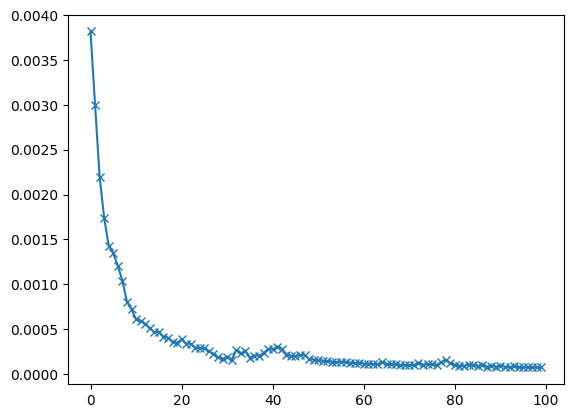

In [20]:
utils.plot_history(drying_history)

In [ ]:
utils.plot_history(cleaning_history)

In [ ]:
utils.plot_history(quenching_history)

In [ ]:
utils.plot_history(salt_history)

In [21]:
model_list = [drying_model, cleaning_model, quenching_model, salt_model]
model_name_list = ['건조', '세정', '소입', '솔트']

for name, model in zip(model_name_list, model_list):
    torch.save({
                'encoder': model.encoder.state_dict(),
                'decoder1': model.decoder1.state_dict(),
                'decoder2': model.decoder2.state_dict()
                }, "./model/"+name+"model.pth")

#### Testing

In [ ]:
for idx, model_name in enumerate(model_name_list):
    checkpoint = torch.load("model.pth")
    model_list[idx].encoder.load_state_dict(checkpoint['encoder'])
    model_list[idx].decoder1.load_state_dict(checkpoint['decoder1'])
    model_list[idx].decoder2.load_state_dict(checkpoint['decoder2'])
    

In [ ]:
drying_result = USAD.testing(model_list[0], test_loader_list[0])
cleaning_result = USAD.testing(model_list[1], test_loader_list[1])
quenching_result = USAD.testing(model_list[2], test_loader_list[2])
salt_result = USAD.testing(model_list[3], test_loader_list[3])